# Project advertising : Classification

Python classification: 
In this project we will be working with a fake advertising data set, indicating whether or not a particular internet user clicked on an Advertisement. You will try to create a model that will predict whether or not they will click on an ad based off the features of that user.

This data set contains the following features:
- 'Daily Time Spent on Site': consumer time on site in minutes
- 'Age': cutomer age in years
- 'Area Income': Avg. Income of geographical area of consumer
- 'Daily Internet Usage': Avg. minutes a day consumer is on the internet
- 'Ad Topic Line': Headline of the advertisement
- 'City': City of consumer
- 'Male': Whether or not consumer was male
- 'Country': Country of consumer
- 'Timestamp': Time at which consumer clicked on Ad or closed window
- 'Clicked on Ad': 0 or 1 indicated clicking on Ad

## 1 - Import libraries

First of some preparation. We need to import python libraries containing the necessary functionality we will need

In [34]:
# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

## 2 - Import data

Firstly, we need to import and visualize our data.

### 2.1 - Load data


In [35]:
df = pd.read_csv('data/AdvertisingforClassification.csv')

### 2.2 -  Statistical summaries and visualizations

To understand the data we are now going to consider some key facts about various variables including their relationship with the target variable, i.e. advertising.

We start by looking at a few lines of the data

In [36]:
df.head()

Daily Time Spent on Site  Age  Area Income  Daily Internet Usage  \
0                     68.95   35     61833.90                256.09   
1                     80.23   31     68441.85                193.77   
2                     69.47   26     59785.94                236.50   
3                     74.15   29     54806.18                245.89   
4                     68.37   35     73889.99                225.58   

                           Ad Topic Line            City  Male     Country  \
0     Cloned 5thgeneration orchestration     Wrightburgh     0     Tunisia   
1     Monitored national standardization       West Jodi     1       Nauru   
2       Organic bottom-line service-desk        Davidton     0  San Marino   
3  Triple-buffered reciprocal time-frame  West Terrifurt     1       Italy   
4          Robust logistical utilization    South Manuel     0     Iceland   

             Timestamp  Clicked on Ad  
0  2016-03-27 00:53:11              0  
1  2016-04-04 01:39:02              0  
2  2016-03-13 20:35:42              0  
3  2016-01-10 02:31:19              0  
4  2016-06-03 03:36:18              0

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.2+ KB


### 2.3 - Key information about the variables


In [38]:
df.describe()

Daily Time Spent on Site          Age   Area Income  \
count               1000.000000  1000.000000   1000.000000   
mean                  65.000200    36.009000  55000.000080   
std                   15.853615     8.785562  13414.634022   
min                   32.600000    19.000000  13996.500000   
25%                   51.360000    29.000000  47031.802500   
50%                   68.215000    35.000000  57012.300000   
75%                   78.547500    42.000000  65470.635000   
max                   91.430000    61.000000  79484.800000   

       Daily Internet Usage         Male  Clicked on Ad  
count           1000.000000  1000.000000     1000.00000  
mean             180.000100     0.481000        0.50000  
std               43.902339     0.499889        0.50025  
min              104.780000     0.000000        0.00000  
25%              138.830000     0.000000        0.00000  
50%              183.130000     0.000000        0.50000  
75%              218.792500     1.000000        1.00000  
max              269.960000     1.000000        1.00000

### 2.4 - Heat map

A heat map of correlation may give us a understanding of which variables are important. It allows us to regroup some lines that are strongly corrolated

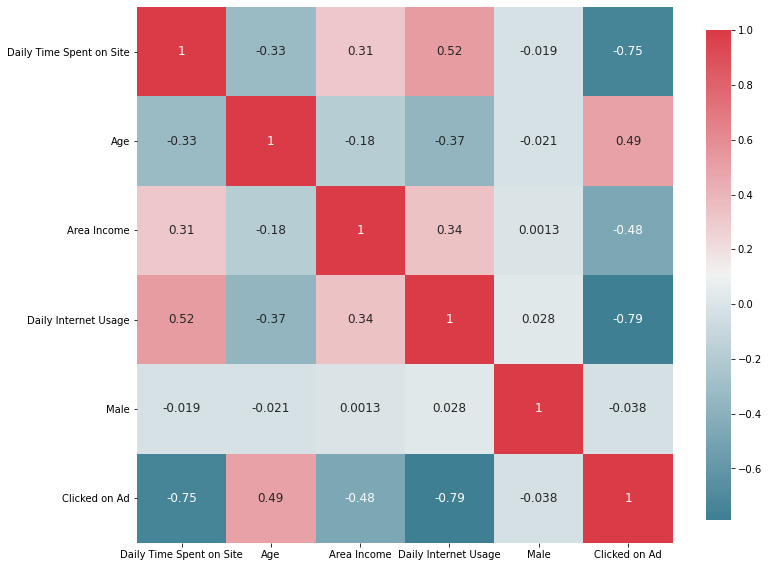

In [39]:
corr = df.corr()
_ , ax = plt.subplots( figsize =( 12 , 10 ) )
cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
_ = sns.heatmap(
    corr, 
    cmap = cmap,
    square=True, 
    cbar_kws={ 'shrink' : .9 }, 
    ax=ax, 
    annot = True, 
    annot_kws = { 'fontsize' : 12 }
)

### 2.5 - Exploratory Data Analysis

In statistics, exploratory data analysis is an approach to analyzing data sets to summarize their main characteristics, often with visual methods.  
EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing task.

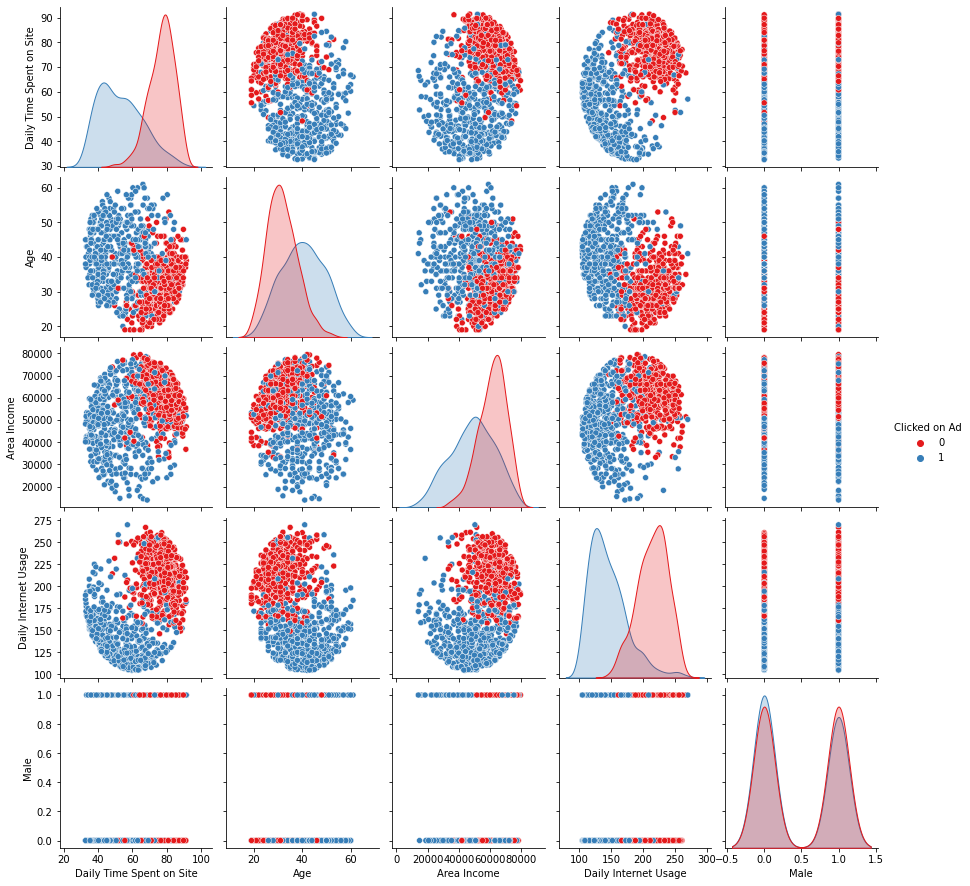

In [40]:
sns.pairplot(df,hue='Clicked on Ad',palette='Set1')

## 3 - Data Preparation

### 3.1 - Final datasets for modelling

We need to select the most important variables to include in the dataset to train our model.

#### 3.1.1 - Sex
Because the sex has next to no impact on our model, we are going to remove it from our dataframe

In [41]:
df = df.drop(['Male'], axis=1)

#### 3.1.2 - Location

To train our model, we are going to transform the Country column from their name to their numeric code.

In [42]:
import pycountry

def get_country_code(x):
    
    try:
        result = pycountry.countries.search_fuzzy(x)
    except Exception:
        return 0
    else:
        return result[0].numeric
    return pycountry.countries.get(name=x).numeric

df['Code'] = df['Country'].apply(get_country_code)



As for the city, there is no easy way to get the local zipcode. Therefor, we are going to simply remove this column from the dataframe.

In [43]:
df = df.drop(['Country'], axis=1)

In [44]:
df = df.drop(['City'], axis=1)

#### 3.1.3 - Ad topic


In [45]:
df = df.drop(['Ad Topic Line'], axis=1)

#### 3.1.4 - Timestamp

In [46]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Weekday'] = df['Timestamp'].dt.weekday


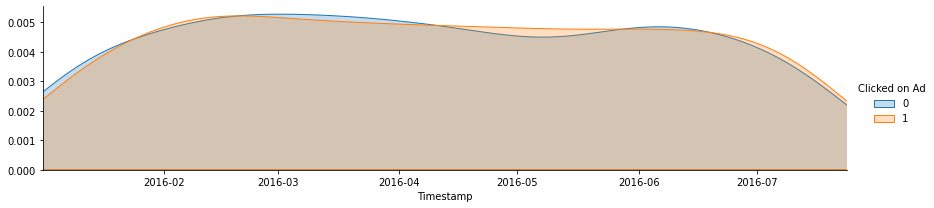

In [47]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( df[ var ].min() , df[ var ].max() ) )
    facet.add_legend()

plot_distribution(df, var='Timestamp', target='Clicked on Ad')

We can see that there is not a lot of information to extract from the raw timestamps. Therefore, we are going to remove it from the dataframe.

In [48]:
df = df.drop(['Timestamp'], axis=1)

### 3.2 - Train Test Split

Let's split up the data into a training set and a test set to see if our model is good and if it is not overfitted.

In [49]:
from sklearn.model_selection import train_test_split
X = df.drop('Clicked on Ad',axis=1)
y = df['Clicked on Ad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

print(X_train.shape, X_test.shape)

(700, 6) (300, 6)


## 4 - Model selection

For our model selection, we are going to fit our data to different models and we are going to select the model with the best results.

In [50]:
models = [RandomForestClassifier(n_estimators=25), SVC(), GradientBoostingClassifier(), KNeighborsClassifier(n_neighbors = 3), GaussianNB()]


best_score = 0
for m in models:
    m.fit( X_train , y_train )
    if m.score( X_test , y_test ) > best_score:
        best_score = m.score( X_test , y_test )
        best_model = m

model = best_model
print (model, model.score( X_train , y_train ) , model.score( X_test , y_test ))

RandomForestClassifier(n_estimators=25) 0.9985714285714286 0.9566666666666667


We can see that the best model here is GaussianNB, and that the accuracy of our model is very good. We can also see that our train and test models are close in score, meaning that our model is not overfitted.

1.0


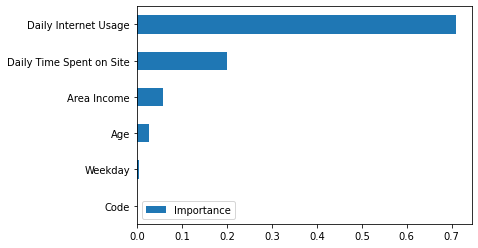

In [51]:
def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 25 ].plot( kind = 'barh' )
    print (model.score( X , y ))

plot_variable_importance(X_train, y_train)

We can see that the country code brings next to none information. If the results we got weren't good enough, we could search if we could 